In [1]:
# import packages
import pandas as pd
import numpy as np
import math
from math import inf
import matplotlib.pyplot as plt
#%matplotlib inline 
from scipy.signal import find_peaks, peak_widths
from scipy.optimize import curve_fit
from scipy.fftpack import fft, fftfreq

In [299]:
# Import EBL and MRFIT data
solute='glutaric acid' # 'NaCl' 'sea spray' or 'glutaric acid' used to determine which RI and density parameterizations to use for analysis
surfactant='C16E8' # TritonX100, SDS, O-b-D-1-TGP, CTAB, Tween20, C10E8, C12E5, C14E6, C16E8, sodium myristate, sodium laurate

massSol= 2.3781/1000 #mass of primary solute in kg
massSurf=((0.1377/250)*17.5)/1000 #mass of surfactant in kg (m1/v1)*v2 = ((0.0103/250)*40)
vSol=0.02 # Solution volume L

f=r'C:\Users\zu21202\OneDrive - University of Bristol\Documents\UoB-PostDoc\HOT-data\header-removed/df-C1Trace05868' #EBL data
data = pd.read_csv(f+'.txt',index_col=0, sep=',')

path=r'C:\Users\zu21202\OneDrive - University of Bristol\Documents\UoB-PostDoc\HOT-data/MRFIT-out/' # MRFIT out file path
fname1='Nov-22-2022_14_49_56parpeaks-IndexAndRadius.txt' #Radius and RI file
ridata1=pd.read_csv(path+fname1,engine='python',sep='\t',index_col=False,header=0)  
ridata=ridata1.iloc[0:len(ridata1)]

c:\Users\zu21202\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


1.3552020478197486 0.00492316789945536 8650.168698525964 362.6818857231238


C:\Users\zu21202\AppData\Local\Temp/ipykernel_3056/4142549471.py:7: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  filt2=disp.between(500,2000,inclusive=True)


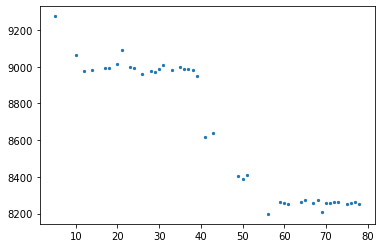

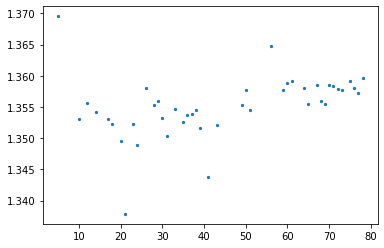

In [309]:
ridata=ridata1.iloc[:] #choose bounds to radius and ri mean
datt=ridata.T
lam=589 #nm
# Improve precision on Radius and RI by dispersion filtering
rad=datt.iloc[1]
disp=datt.iloc[3]
filt2=disp.between(500,2000,inclusive=True)
ri2=ridata[filt2].m0+ridata[filt2].m1/lam**2#+data.m2/lam**4
meanri=np.mean(ri2)
sdri=np.std(ri2)
meanrad=np.mean(rad[filt2])
sdrad=np.std(rad[filt2])

print(meanri,sdri,meanrad,sdrad)
plt.scatter(ridata[filt2].index+1,ridata[filt2].Radius,s=5)
plt.show()
plt.scatter(ridata[filt2].index+1,ri2,s=5)
plt.show()

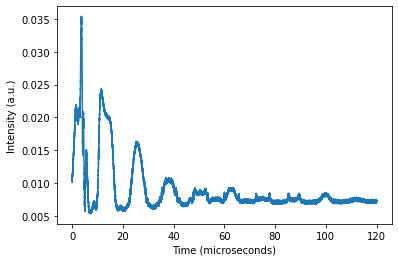

In [304]:
x1=data.Time.to_numpy()
x2=np.where(x1<0) # find min index where t=0

x1=np.where(x1>0.00012) # tmax in second
x1=x1[0]
x2=x2[0]
maxindex=x1[0]
minindex=x2[len(x2)-1]

datacut=data.Ampl[minindex:maxindex]
timecut1=data.Time[minindex:maxindex]
datacut1=datacut.to_numpy()
timecut1=timecut1.to_numpy()

# Autocrop EBL trace by finding end of oscillations
# b1=np.mean(datacut[10000:len(datacut)]) # long time baseline
# indices=find_peaks(datacut,height=[b1*1.2,b1*10])[0] # find peaks
# y2 = datacut1*-1 + max(datacut1) # Invert trace
# b2=np.mean(y2[10000:len(y2)]) # long time basleine of inverse spectrum
# minima = find_peaks(y2,height=[b2*1.1,b2*10])[0] # find minima
# lastpeakmax=minindex+indices[-1] # final peak 
# lastpeakmins=minindex+minima[-1] # final trough
# lastpeak=int(np.max([lastpeakmax,lastpeakmins])*1.05) # peak/trough at longest time point +5%

####### Alternative manual crop of EBL trace #######
# x1=np.where(x1>0.00006) # tmax in second
# x1=x1[0]
# lastpeak=x1[0]
#######

# datacut2=data.Ampl[minindex:lastpeak]
# timecut2=data.Time[minindex:lastpeak]
# datacut2=datacut2.to_numpy()
# timecut2=timecut2.to_numpy()

plt.plot(timecut1*1000000,datacut1)
plt.xlabel('Time (microseconds)')
plt.ylabel('Intensity (a.u.)')
plt.show()

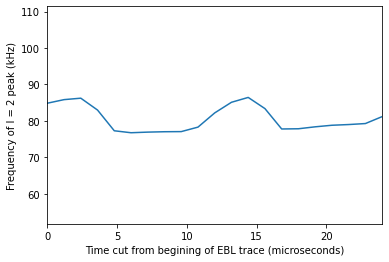

In [305]:
def lorentzian( x, x0, a, gam ):
    return a * gam**2 / ( gam**2 + ( x - x0 )**2)

wLlist=[] # list of frequencies calculated from a Lorentzian fit 
wLtime=[] # list of time points cut from begining of trace for FFT & resulting Lorentizan fit 
i=0
pct=0.2 #percent of trance to cut 
while i<len(datacut1)*pct: # set arbrutrary number of points to remove from begining of trace - 20% of the points
    datacut=datacut1[i:len(datacut1)]
    timecut=timecut1[i:len(timecut1)]
    N = len(timecut) # number of datapoints
    DURATION = max(timecut)-min(timecut) # duration of measurment 
    yf = fft(datacut)
    xf = fftfreq(N, DURATION/N)
    y=np.abs(yf[1:len(yf)])
    x=xf[1:len(yf)]
    indices=find_peaks(y,height=[0.5*max(y),max(y)])[0] #height=[min(y),max(y)]
    if len(indices)==0: # if could not find a peak to fit set frequency to 1 - filter out later
        omega2=1
    else:
        t=y[indices]
        m=np.argmax(t)
        if indices[m]<3:
            cutmin=1
            cutmax=indices[m]+3
        else:  
            cutmin=indices[m]-3 # minimum index fitting boundry 3 works for long trace, cut to 2 if ST comes out orders of magnutude too high
            cutmax=indices[m]+3
        xcut=x[cutmin:cutmax]
        ycut=y[cutmin:cutmax]
        # fit 1 Lorentzian over fitting boundry indecies with starting guesses p0=[x0,a,gam]
        popt,pcov = curve_fit(lorentzian, xcut, ycut,maxfev=1000000000,p0=(x[indices[m]],max(y),200)) 
        omega2=popt[0] #frequency from Lorentzian fit of FFT of ELB trace
    # fitx=np.linspace(min(xcut),max(xcut),100)
    # fity=lorentzian( fitx, popt[0], popt[1], popt[2])  
    # plt.plot(x/1000, y)
    # plt.scatter(x[indices[0]]/1000,y[indices[0]],color='red') 
    # plt.plot(fitx/1000,fity)  
    # plt.xlim([1,800])
    # plt.xlabel("Frequency (kHz)")
    # plt.ylabel("Magnitude (a.u.)")
    # plt.show()
    wLlist=np.append(wLlist,omega2)
    wLtime=np.append(wLtime,min(timecut))
    i=i+round(len(datacut1)*pct/20) # cut ELB trace by percent pct in 20 equally spaced steps

# plt.plot(wlist)
plt.plot(wLtime*1000000,wLlist/1000)
plt.xlim([0,max(wLtime)*1000000])
plt.ylim([min(wLlist/1000)-25,max(wLlist/1000)+25])
#plt.legend(["FFT max","Centre of Lorentzian"])
plt.xlabel("Time cut from begining of EBL trace (microseconds)")
plt.ylabel("Frequency of l = 2 peak (kHz)")
plt.show()


In [306]:
#Solute parameters
ri=np.mean(ri2)
T = 295 #Temperature in K
# NaCl and glutaric acid parameterization from: Bzdek, B. R., Power, R. M., Simpson, S. H., Reid, J. P., & Royall, C. P. (2016). Precise, contactless measurements of the surface tension of picolitre aerosol droplets. Chemical Science, 7(1), 274–285. http://doi.org/10.1039/c5sc03184b Error in viscosity parameterization for glutaric acid. First term should be ^2
if solute == 'glutaric acid':
    molarity=5.8647*ri**3+12.804*ri**2+2.4342*ri-39.875 #mol/L
    rho=-0.4163*molarity**2+32.736*molarity+997.28 # kg m^-3 !! Fit viscosity data from Song, Y. C., Haddrell, A. E., Bzdek, B. R., Reid, J. P., Bannan, T., Topping, D. O., … Cai, C. (2016). Measurements and Predictions of Binary Component Aerosol Particle Viscosity. Journal of Physical Chemistry A, 120(41), 8123–8137. http://doi.org/10.1021/acs.jpca.6b07835 to double check parameterization 
    visc=9.52*10**-5*molarity**2+1.509*10**-4*molarity+9.017*10**-4 # Pa*s
    MW=132.12/1000 #molecular mass glutaric acid (kg/mol)
    fname=r'C:\Users\zu21202\OneDrive - University of Bristol\Documents\Python\AIOMFAC/AIOMFAC-Glutaric-Acid-H2O-295.txt' 
elif solute == 'NaCl':
    #molarity= -287.3*ri**3 + 1322.3*ri**2 - 1877.3*ri + 833.2 #mol/L Chem. Sci. 2016
    molarity = -1.32107*10**3*ri**3 + 5.71968*10**3*ri**2 - 8.10936*10**3*ri + 3.77562*10**3 #CRC parameterization
    rho= 3.506*10**-3*molarity**2 + 35.06*molarity + 1000.6# kg m^-3
    visc= 4*10**-5*molarity**2 + 10**-4*molarity + 1.1*10**-3# Pa*s
    MW=58.44277/1000 #molecular mass NaCl (kg/mol)
    fname=r'C:\Users\zu21202\OneDrive - University of Bristol\Documents\Python\AIOMFAC/AIOMFAC-NaCl-H2O-295.txt'
elif solute == 'sea spray':
    molarity = 82.919*ri-110.54 # parameterized data in 0.5M region
    rho=-3.1*molarity**2 + 51.1*molarity + 998.6# kg m^-3
    visc= 4*10**-5*molarity**2 + 10**-4*molarity + 1.1*10**-3# Pa*s Assume same viscisity as NaCl
    MW=58.44277/1000 #molecular mass NaCl (kg/mol)
    fname=r'C:\Users\zu21202\OneDrive - University of Bristol\Documents\Python\AIOMFAC/AIOMFAC-NaCl-H2O-295.txt'

wB=molarity*MW/rho*1000

#import activity data - AIOMFAC    
dat=pd.read_table(fname,header=None) #read file
dat.T
wb=1-dat[6] # mass fraction 
act=dat[14] # activity
def aw_fun(wB):
    return np.interp(wB, wb, act) # water activity parameterization


#Surfactant Parameters
if surfactant == 'TritonX100':
    MWsurf = 646.86/1000 #kg/mol
elif surfactant == 'SDS':
    MWsurf = 288.372/1000  #kg/mol
elif surfactant == 'O-b-D-1-TGP':
     MWsurf = 308.43/1000  #kg/mol
elif surfactant == 'CTAB':
    MWsurf = 364.45/1000  #kg/mol
elif surfactant == 'Tween20':
    MWsurf = 1227.53/1000  #kg/mol
elif surfactant == 'C10E8':
    MWsurf = 510.7/1000 #kg/mol
elif surfactant == 'C12E5':
    MWsurf = 406.6/1000  #kg/mol
elif surfactant == 'C14E6':
    MWsurf = 478.703/1000  #kg/mol
elif surfactant == 'C16E8':
    MWsurf = 594.86/1000  #kg/mol
elif surfactant == 'sodium myristate':
    MWsurf = 250.35/1000 #kg/mol
elif surfactant == 'sodium laurate':
    MWsurf = 222.3/1000 #kg/mol
elif surfactant == 'sodium caprate':
    MWsurf = 194.25/1000 #kg/mol
elif surfactant == 'sodium caprylate':
    MWsurf = 166.2/1000 #kg/mol

if solute == 'sea spray':
    molSol=0.48 # 0.48 M 
    molSurf=massSurf/(vSol*MWsurf) # M 
    ratio=molSurf/molSol
    consurf=molarity*ratio*1000 #concentration of surfactant mM 
else:
    molSol=massSol/(vSol*MW)
    molSurf=massSurf/(vSol*MWsurf)
    ratio=molSurf/molSol
    consurf=molarity*ratio*1000 #concentration of surfactant mM 

In [307]:
wLlistfilt = [i for i in wLlist if i >= 1] #remove any bad frequency points (below 1 Hz)
wlListfilt=np.array(wLlistfilt)
#wlListfilt=wlListfilt[8:len(wlListfilt)] # remove more points if needed
omegaL=wlListfilt*2*np.pi
#omegaL=wLlistfilt*2*np.pi # observed anglular frequency Hz of l=2 mode from Lorentzian
omegaLmax=max(omegaL)
omegaLmean=np.mean(omegaL)
l=2# mode order
a = (meanrad)*10**(-9) #radius in m
aw = aw_fun(wB)

tao=(a**2*rho)/((l-1)*(2*l+1)*visc) # Characteristic Damping [Hz]  
omega_cor_mean=((omegaLmean**2 + tao**-2)**0.5)
st2=((omega_cor_mean)**2*rho*a**3)/(l*(l-1)*(l+2)) # Hz^2 kg/m^3 m^3 = kg s^-2 = N m^-1
surften_mean=st2*1000 # mN/m
st=((omegaLmean)**2*rho*a**3)/(l*(l-1)*(l+2)) # Hz^2 kg/m^3 m^3 = kg s^-2 = N m^-1
surften_meanL=st*1000 # mN/m

print(str(surften_meanL)+' '+str(surften_mean)+' '+str(aw)+' '+str(molarity)+' '+str(consurf)+' '+str(meanrad))

24.226312816123233 24.794995546373585 0.9756825219753505 1.4145808925703065 1.2734545608563481 8983.746396706798


In [298]:
header='surface_tension(mN/m)'+' '+'surface_tension_visccor(mN/m)'+' '+'water_activity'+' '+'psolute_molarity(M)'+' '+'surfactant_molarity(mM)'+' '+'radius(nm)'+' '+'RI(nm)'+' '+'fileID'
string=str(surften_meanL)+' '+str(surften_mean)+' '+str(aw)+' '+str(molarity)+' '+str(consurf)+' '+str(meanrad)+' '+str(meanri)+' '+fname1 

#Open the file in append & read mode ('a+')
with open("ST-GA-C16E8-more.txt", "a+") as file_object:
    # Move read cursor to the start of file.
    file_object.seek(0)
    # If file is not empty then append '\n'
    data = file_object.read(100)
    if len(data) > 0 :
        file_object.write("\n")
    file_object.write(string)